In [12]:
from models.datasets import MonumentsDataset
from models import datasets
from models.utils import get_train_transform, collate_fn
from models import fasterrcnn
from datasets import class_list
from torch.utils.data import DataLoader

In [13]:
model = fasterrcnn.fasterrcnn_resnet50_fpn(num_classes=17)

In [14]:
import torch
model_path="E:\Major Project\Continual-Monument-Detection\models\saved\model10 (1).pth"
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
# weights=torch.load(model_path)

<All keys matched successfully>

In [15]:
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [16]:
clases=['kiranteshwor mahadev', 'charumati', 'kumaristhan', 'ume_maheshwara', 'jaya bageshwori', 'birupakshya', 'Naxal Bhagwati', 'Krishna_temple _kobahal', 'chakku bakku', 'golden temple', 'Ram Mandir', 'uma maheshwor', 'Maitidevi Temple', 'guyeshwori', 'nagarmandap shree kriti bihar', 'Jalbinayak']

In [17]:
TRAIN_DIR = "E:\Major Project\Continual-Monument-Detection\dataset"
dataset = MonumentsDataset(TRAIN_DIR, 512, 512, clases, get_train_transform())

['IMG20230626113905.jpg', 'IMG20230626113906.jpg', 'IMG20230626113907.jpg', 'IMG20230626113908.jpg', 'IMG20230626113912.jpg']


In [18]:
import torch
indices = torch.randperm(len(dataset)).tolist()
print(len(indices))
print(indices[:20])

8660
[7303, 3384, 5317, 1146, 5947, 8042, 2283, 2030, 6953, 7997, 1174, 2543, 6784, 7124, 7215, 6949, 7571, 3302, 6287, 4065]


In [19]:
train_set = torch.utils.data.Subset(dataset, indices[:-500])
eval_set=torch.utils.data.Subset(dataset, indices[-500:])

In [20]:
len(eval_set)

500

In [21]:
valid_loader = DataLoader(
    eval_set,
    batch_size=5,
    shuffle=True,
    num_workers=2,
    collate_fn=collate_fn
    )

In [22]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(DEVICE)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [23]:
from torch import tensor
predictions=[{'boxes': tensor([[ 84.1036,  76.5165, 271.7503, 443.8830],[ 84.1036,  76.5165, 271.7503, 443.8830],
                    [ 84.1036,  76.5165, 271.7503, 443.8830],
                    [ 84.1036,  76.5165, 271.7503, 443.8830],]), 
              'labels': tensor([1, 1, 4,6]),
              'scores': tensor([0.9965,0.8, 0.2779, 0.0586])},
             {'boxes': tensor([[239.2319, 219.7705, 343.4445, 404.7963]]),
              'labels': tensor([5]),
              'scores': tensor([0.9982])},
             {'boxes': tensor([[ 77.5203,  86.0100, 506.1534, 484.8054]]),
              'labels': tensor([12]),
              'scores': tensor([0.9954])},
             {'boxes': tensor([[134.1839, 174.5545, 394.9434, 375.4676],
                               [106.7353, 121.3933, 373.4354, 412.4706]]),
              'labels': tensor([8, 2]),
              'scores': tensor([0.9917, 0.0847])},
             {'boxes': tensor([[106.1037,  84.3046, 465.6261, 400.9447],
                               [146.9601, 165.3507, 469.2495, 417.4515],
                               [ 61.8506,  23.7119, 470.3089, 432.0762],
                               [ 86.0900,  59.0844, 436.2623, 460.5981],
                               [134.8938,  92.4572, 458.3427, 414.5243],
                               [ 36.1431,  89.5182, 480.6086, 381.3042],
                               [140.2368, 103.6454, 453.7489, 434.0392]]),
              'labels': tensor([ 3,  8,  4, 12,  6,  8,  7]),
              'scores': tensor([0.8088, 0.4658, 0.2955, 0.2125, 0.1203, 0.0985, 0.0970])}]

targets=[{'boxes': tensor([[ 84.1036,  76.5165, 271.7503, 443.8830],
                    ]), 
              'labels': tensor([1, ]),
              'scores': tensor([0.9965])},
             {'boxes': tensor([[239.2319, 219.7705, 343.4445, 404.7963]]),
              'labels': tensor([5]),
              'scores': tensor([0.9982])},
             {'boxes': tensor([[ 77.5203,  86.0100, 506.1534, 484.8054]]),
              'labels': tensor([8]),
              'scores': tensor([0.9954])},
             {'boxes': tensor([[134.1839, 174.5545, 394.9434, 375.4676]]),
              'labels': tensor([8]),
              'scores': tensor([0.9917])},
             {'boxes': tensor([[106.1037,  84.3046, 465.6261, 400.9447]
                              ]),
              'labels': tensor([3]),
              'scores': tensor([0.8088])}]

In [24]:
def filter_preds(predicted,threshold=0.6):
    filtered_predictions = []

    for pred in predicted:
        scores = pred['scores']
        indices = scores > threshold
        if indices.any():
            filtered_boxes = pred['boxes'][indices]
            filtered_labels = pred['labels'][indices]
            filtered_scores = pred['scores'][indices]
            filtered_pred = {'boxes': filtered_boxes,
                             'labels': filtered_labels,
                             'scores': filtered_scores}
        else:
            filtered_boxes = torch.tensor([[0, 0, 0, 0]])
            filtered_labels = torch.tensor([0])
            filtered_scores =torch.tensor([0])
            filtered_pred = {'boxes': filtered_boxes,
                             'labels': filtered_labels,
                             'scores': filtered_scores}
        filtered_predictions.append(filtered_pred)
    return filtered_predictions

In [25]:
import numpy as np
from sklearn.metrics import confusion_matrix
from torch import tensor
def sort_predictions(predictions,targets,threshold=0.6):
    target_labels=[]
    pred_labels=[]
    for target,prediction in zip(targets,predictions):
        for i, box in enumerate(target['boxes']):
            for j, pbox in enumerate(prediction['boxes']):
                intersection=(min(box[2],pbox[2])-max(box[0],pbox[0]))*(min(box[3],pbox[3])-max(box[1],pbox[1]))
                union=(box[2]-box[0])*(box[3]-box[1])+ (pbox[2]-pbox[0])*(pbox[3]-pbox[1])-intersection
                iou=intersection/union
                if (iou>0.6):
                    label=target['labels'][i]
                    output=prediction['labels'][j]
                    target_labels.append(label)
                    pred_labels.append(output)
                else:
                    continue
    print(f'Print {len(pred_labels)} predictions')
    return target_labels,pred_labels

In [26]:
filtered_predictions=filter_preds(predictions,0.6)
target_labels, pred_labels=sort_predictions(filtered_predictions,targets,0.6)                
conf_matrix = confusion_matrix(target_labels, pred_labels)
print(target_labels)
print(pred_labels)
print("Confusion Matrix:")
print(conf_matrix)

Print 6 predictions
[tensor(1), tensor(1), tensor(5), tensor(8), tensor(8), tensor(3)]
[tensor(1), tensor(1), tensor(5), tensor(12), tensor(8), tensor(3)]
Confusion Matrix:
[[2 0 0 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 0 0 1 1]
 [0 0 0 0 0]]


In [27]:
# generate classification report for the predictions
from sklearn.metrics import classification_report
report=classification_report(target_labels,pred_labels)
print(report)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         1
           8       1.00      0.50      0.67         2
          12       0.00      0.00      0.00         0

    accuracy                           0.83         6
   macro avg       0.80      0.70      0.73         6
weighted avg       1.00      0.83      0.89         6



E:\Major Project\Continual-Monument-Detection\venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Major Project\Continual-Monument-Detection\venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Major Project\Continual-Monument-Detection\venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
original=[]
predicted=[]
with torch.no_grad():
    for batch in valid_loader:
        images, targets = batch
        images = list(image.to(DEVICE) for image in images)
        target = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]  
        original.extend(target)
        predictions = model(images)
        predicted.extend(predictions)

In [29]:
filtered_predictions=filter_preds(predicted,0.6)
target_labels, pred_labels=sort_predictions(filtered_predictions,original,0.6)                
conf_matrix = confusion_matrix(target_labels, pred_labels)
print(target_labels)
print(pred_labels)
print("Confusion Matrix:")
print(conf_matrix)

Print 460 predictions
[tensor(7), tensor(7), tensor(1), tensor(3), tensor(3), tensor(5), tensor(4), tensor(13), tensor(2), tensor(1), tensor(7), tensor(6), tensor(11), tensor(9), tensor(5), tensor(13), tensor(1), tensor(9), tensor(9), tensor(0), tensor(2), tensor(0), tensor(3), tensor(4), tensor(10), tensor(5), tensor(9), tensor(5), tensor(0), tensor(10), tensor(12), tensor(10), tensor(10), tensor(5), tensor(0), tensor(11), tensor(10), tensor(7), tensor(12), tensor(10), tensor(14), tensor(12), tensor(10), tensor(4), tensor(8), tensor(13), tensor(11), tensor(1), tensor(1), tensor(9), tensor(13), tensor(2), tensor(15), tensor(15), tensor(5), tensor(8), tensor(1), tensor(10), tensor(0), tensor(5), tensor(12), tensor(9), tensor(10), tensor(3), tensor(13), tensor(0), tensor(8), tensor(2), tensor(2), tensor(9), tensor(15), tensor(3), tensor(2), tensor(8), tensor(1), tensor(3), tensor(15), tensor(15), tensor(12), tensor(12), tensor(9), tensor(0), tensor(13), tensor(2), tensor(11), tensor(1), 

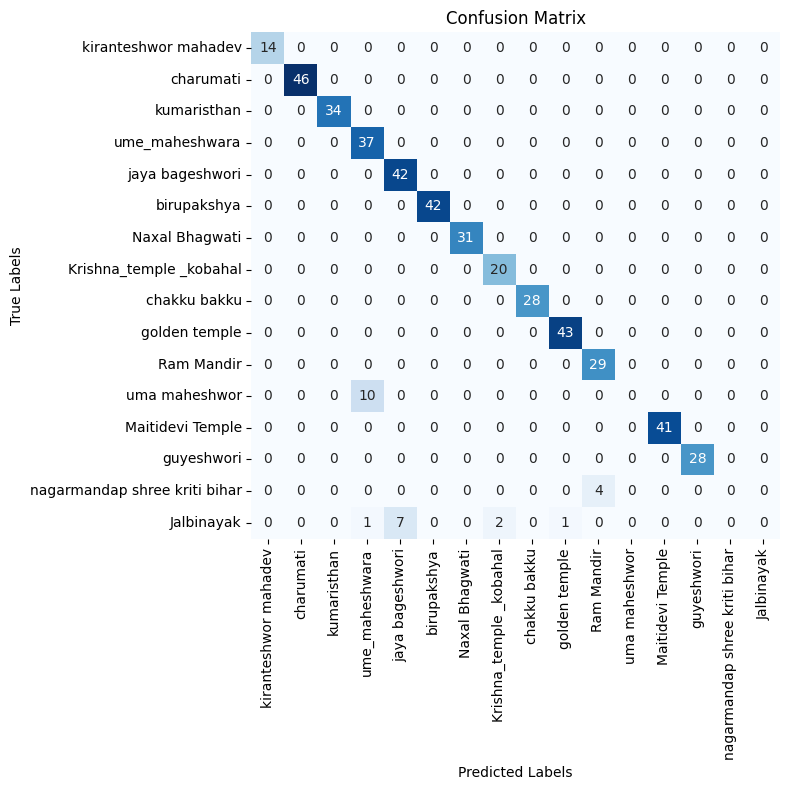

In [30]:
# plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,xticklabels=clases, yticklabels=clases)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=None, bbox_inches='tight', format='png')
plt.show()

In [31]:
report=classification_report(target_labels,pred_labels)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00        46
           2       1.00      1.00      1.00        34
           3       0.77      1.00      0.87        37
           4       0.86      1.00      0.92        42
           5       1.00      1.00      1.00        42
           6       1.00      1.00      1.00        31
           7       0.91      1.00      0.95        20
           8       1.00      1.00      1.00        28
           9       0.98      1.00      0.99        43
          10       0.88      1.00      0.94        29
          11       0.00      0.00      0.00        10
          12       1.00      1.00      1.00        41
          13       1.00      1.00      1.00        28
          14       0.00      0.00      0.00         4
          15       0.00      0.00      0.00        11

    accuracy                           0.95       460
   macro avg       0.77   

E:\Major Project\Continual-Monument-Detection\venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Major Project\Continual-Monument-Detection\venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Major Project\Continual-Monument-Detection\venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

In [32]:
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Assuming 'original' is a list of dictionaries where each dictionary contains the 'image' tensor and 'boxes' tensor for the ground truth bounding boxes
# Assuming 'predicted' is a list of dictionaries where each dictionary contains the 'image' tensor and 'boxes' tensor for the predicted bounding boxes

# Convert the 'image' tensors and 'boxes' tensors from the dictionaries to NumPy arrays
images_cpu = [image.cpu() for image in photos]

# Convert the CPU tensors to NumPy arrays
original_np = [image.numpy() for image in images_cpu]
predicted_np = original_np
predicted_label=[item['labels'].cpu().numpy() for item in filtered_predictions]
# original_np = [item['image'].cpu().numpy() for item in original]
original_boxes = [item['boxes'].cpu().numpy() for item in original]
# predicted_np = [item['image'].cpu().numpy() for item in predicted]
predicted_boxes = [item['boxes'].cpu().numpy() for item in filtered_predictions]

# Visualize the original and predicted images with bounding boxes
fig, axs = plt.subplots(len(original), 2, figsize=(10, 5 * len(original)))

for i in range(len(original)):
    image_bgr = original_np[i].transpose(1,2,0)[:, :, ::-1]
    # Original Image
    axs[i, 0].imshow(image_bgr)  # Assuming original images are in CHW format
    axs[i, 0].axis('off')
    axs[i, 0].set_title('Original')

    # Predicted Image with Bounding Boxes
    axs[i, 1].imshow(image_bgr)  # Assuming predicted images are in CHW format
    axs[i, 1].axis('off')
    axs[i, 1].set_title('Predicted')

    # Add ground truth bounding boxes to the original image
    for box in original_boxes[i]:
        rect = patches.Rectangle(
            (box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=2, edgecolor='r', facecolor='none'
        )
        axs[i, 0].add_patch(rect)
#         axs[i,0].text(
#             box[0], box[1] - 5, f'{clases[int(predicted_label[i])-1]}', color='r', fontsize=10,
#             bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.2')
#         )
        axs[i, 0].add_patch(rect)
        axs[i,0].text(
            box[0], box[1] - 5, f'jal binayak', color='r', fontsize=10,
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.2')
        )


    # Add predicted bounding boxes to the predicted image
    for box in predicted_boxes[i]:
        rect = patches.Rectangle(
            (box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=2, edgecolor='g', facecolor='none'
        )
#         axs[i, 1].add_patch(rect)
#         axs[i,1].text(
#             box[0], box[1] - 5, f'{clases[int(predicted_label[i])-1]}', color='r', fontsize=10,
#             bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.2')
#         )
        axs[i, 1].add_patch(rect)
        axs[i,1].text(
            box[0], box[1] - 5, f'kiranteswor mahadev', color='r', fontsize=10,
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.2')
        )

plt.tight_layout()
plt.show()

NameError: name 'photos' is not defined